In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display

## TF-IDF
- Term Frequency-Inverse Document Frequency
- Words that appear in many documents are less meaningful (Eg: the, a, an...)
$$\frac{Word\ count}{Document\ count}$$

## Word Embedding
- Embedd words into a vector space
<img src="./img/1.jpg" alt="drawing" width="400"/>

<img src="./img/2.jpg" alt="drawing" width="400"/>

- V: Vocabulary size (# of words)
- D: Vector dimensionality (features)

### Word Analogy
```
woman - man ~= Queen - King
```
- Distance
    + Euclidean distance: $|a-b|$
    + Cosine distance: $1 - \frac{a^Tb}{|a||b|}$

## T-SNE Dimensionality Reduction
- TF-IDF produces high dimensions across documents
- t-SNE can help reduce the dimensionality

### Dataset

In [2]:
from keras.datasets import imdb

# dataset set: 
#     + X: 25000 trainning paragraphs, 25000 Testing paragraphs
#          each word is mapped as a number
#     + y: 0 or 1
(X_train, y_train), (X_test, y_test) = imdb.load_data(
    '/tmp/imdb.npz',
    num_words=None,
    skip_top=0,
    maxlen=None,
    start_char=1,
    oov_char=2,
    index_from=3)

# Word Index
word2idx = imdb.get_word_index()
display(len(word2idx))

# Reverse Word index
idx2word = {v+3:k for k,v in word2idx.items()}
idx2word[0] = 'padding_char'
idx2word[1] = 'start_char'
idx2word[2] = 'oov_char'
idx2word[3] = 'unk_char'

Using TensorFlow backend.


88584

### Reduce index and dataset to speed up trainning

In [3]:
from_ = 1000
to_ = 1500

# Reduce Dataset
df = pd.DataFrame(
    X_train[from_:to_],
    columns=['Sentences'])

df['Reconstruct Sentences'] = df['Sentences'] \
    .apply(lambda x: ' '.join([idx2word[word] for word in x]))

df.head()

,Sentences,Reconstruct Sentences
0,"[1, 261, 13, 69, 110, 15394, 11, 6, 750, 96, 1...",start_char although i had seen gymkata in a th...
1,"[1, 13, 69, 115, 110, 6, 1295, 20, 366, 7084, ...",start_char i had never seen a silent movie unt...
2,"[1, 684, 91, 529, 694, 164, 44, 4, 479, 7, 238...",start_char apparently most viewer knows nothin...
3,"[1, 55, 3382, 1361, 10, 10, 14, 20, 466, 112, ...",start_char very slight spoiler br br this movi...
4,"[1, 11, 31, 1161, 45, 40, 1065, 4602, 7, 4493,...",start_char in one respect it's like 'the wizar...


In [4]:
# Reduce index
reconstruct_sentences = df['Reconstruct Sentences'].values
new_sentences = []

idx = {}
idx['padding_char'] = 0
idx['start_char'] = 1
idx['oov_char'] = 2
idx['unk_char'] = 3

num = 4

for sentence in reconstruct_sentences:
    new_sentence = []
    for word in sentence.split(' '):
        # Update
        if word not in idx:
            idx[word] = num
            num += 1
        
        # Rebuild sentence
        new_sentence.append(idx[word])
    new_sentences.append(new_sentence)
    
# Update sentences
sentences = np.array(new_sentences)

# update reduced index
word2idx = idx
idx2word = {v:k for k,v in word2idx.items()}

display(len(word2idx))

13002

In [5]:
# Rebuild dataset
df = pd.DataFrame(
    sentences,
    columns=['Sentences'])
df['Reconstruct Sentences'] = df['Sentences'].apply(lambda x: ' '.join([idx2word[word] for word in x]))

df.head()

,Sentences,Reconstruct Sentences
0,"[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 9, 14, 5...",start_char although i had seen gymkata in a th...
1,"[1, 5, 6, 113, 7, 10, 185, 186, 187, 188, 189,...",start_char i had never seen a silent movie unt...
2,"[1, 261, 229, 262, 263, 264, 265, 19, 266, 18,...",start_char apparently most viewer knows nothin...
3,"[1, 196, 366, 367, 37, 37, 57, 186, 368, 369, ...",start_char very slight spoiler br br this movi...
4,"[1, 9, 59, 424, 425, 98, 426, 427, 18, 428, 42...",start_char in one respect it's like 'the wizar...


### Tf-idf

In [6]:
# build term document matrix
V = len(word2idx)
D = len(sentences)

print(V, D)

13002 500


#### Raw word count

In [7]:
# create raw counts first
A = np.zeros((V, D))

j = 0
for sentence in sentences:
    for word in sentence:
        A[word, j] += 1
    j += 1
print("finished getting raw counts")

finished getting raw counts


#### TF-IDF transform

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
A = transformer.fit_transform(A.T).T

A.shape

(13002, 500)

#### T-sne transform (2D)

In [9]:
# tsne requires a dense array
A = A.toarray()
display(A.shape)

# t-sne
from sklearn.manifold import TSNE

tsne = TSNE()
Z = tsne.fit_transform(A)

display(Z.shape)

(13002, 500)

(13002, 2)

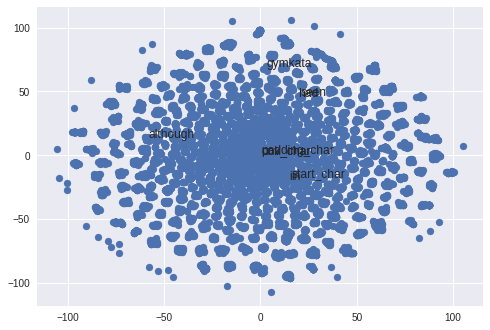

In [10]:
plt.scatter(Z[:,0], Z[:,1])
for i in range(10):
    try:
        plt.annotate(s=idx2word[i].encode("utf8").decode("utf8"), xy=(Z[i,0], Z[i,1]))
    except:
        print("bad string:", idx2word[i])

plt.draw()

#### T-sne transform (3D)

In [11]:
tsne = TSNE(n_components=3)
We = tsne.fit_transform(A)

We.shape

(13002, 3)

In [0]:
from sklearn.metrics.pairwise import pairwise_distances


def find_analogies(w1, w2, w3, We, word2idx, idx2word):
    V, D = We.shape

    king = We[word2idx[w1]]
    man = We[word2idx[w2]]
    woman = We[word2idx[w3]]
    v0 = king - man + woman

    for dist in ('euclidean', 'cosine'):
        distances = pairwise_distances(v0.reshape(1, D), We, metric=dist).reshape(V)
        # idx = distances.argmin()
        # best_word = idx2word[idx]
        idx = distances.argsort()[:4]
        best_idx = -1
        keep_out = [word2idx[w] for w in (w1, w2, w3)]
        for i in idx:
            if i not in keep_out:
                best_idx = i
                break
        best_word = idx2word[best_idx]


        print("closest match by", dist, "distance:", best_word)
        print(w1, "-", w2, "=", best_word, "-", w3)

In [13]:
analogies_to_try = (
        ('king', 'man', 'woman'),
        ('france', 'paris', 'london'),
        ('france', 'paris', 'rome'),
        ('paris', 'france', 'italy'))

for word_list in analogies_to_try:
        w1, w2, w3 = word_list
        find_analogies(w1, w2, w3, We, word2idx, idx2word)

closest match by euclidean distance: probably
king - man = probably - woman
closest match by cosine distance: laugh
king - man = laugh - woman
closest match by euclidean distance: brooklyn
france - paris = brooklyn - london
closest match by cosine distance: chose
france - paris = chose - london
closest match by euclidean distance: jokes
france - paris = jokes - rome
closest match by cosine distance: jokes
france - paris = jokes - rome
closest match by euclidean distance: week
paris - france = week - italy
closest match by cosine distance: bus
paris - france = bus - italy
